<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Pedro_Cintra/Exerc%C3%ADcio_6_235648.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = 'Pedro Henrique Pinheiro Cintra'

print(f'Meu nome é {nome}')

Meu nome é Pedro Henrique Pinheiro Cintra


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [4]:
batch_size = 50

## Download do CIFAR-10

In [5]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [6]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

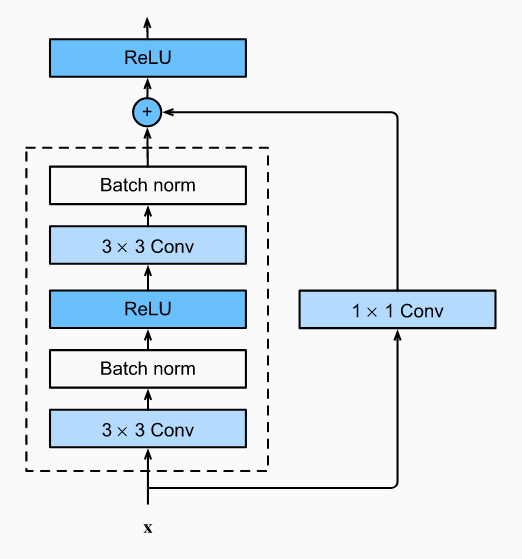

In [8]:
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        self.stride = stride

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size = 1, stride = stride, padding = 0, bias = False)


    def forward(self, x: Tensor) -> Tensor:
        # Bloco
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Downsample
        downs= self.downsample(x)
        # Soma do downsample com o bloco
        out += downs
        # Ativação ReLU
        out = self.relu(out)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [9]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [23]:
from collections import OrderedDict
# Usei a ideia da Larissa Santesso de usar o OrderedDict para compactar o código

class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.layer0 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)),
            ('MaxPool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
            ('BatchNorm', nn.BatchNorm2d(64)),
            ('Relu', nn.ReLU())
        ]))

        self.layer1 = nn.Sequential(OrderedDict([
            ('Block1', MyBasicBlock(64, 64, stride = stride)),
            ('Block2', MyBasicBlock(64, 64, stride = stride))
        ]))

        self.layer2 = nn.Sequential(OrderedDict([
            ('Block3', MyBasicBlock(64, 128, stride = stride)),
            ('AvgPool1', nn.AdaptiveAvgPool2d(1)),
            ('Block4', MyBasicBlock(128, 128, stride = stride))
        ]))

        self.layer3 = nn.Sequential(OrderedDict([
            ('Block5', MyBasicBlock(128, 256, stride = stride)),
            ('AvgPool2', nn.AdaptiveAvgPool2d(1)),
            ('Block6', MyBasicBlock(256, 256, stride = stride))
        ]))


        self.layer4 = nn.Sequential(OrderedDict([
            ('Block7', MyBasicBlock(256, 512, stride = stride)),
            ('AvgPool3', nn.AdaptiveAvgPool2d(1)),
            ('Block8', MyBasicBlock(512, 512, stride = stride))
        ]))

        self.layer5 = nn.Sequential(OrderedDict([
            ('Block7', MyBasicBlock(512, 1024, stride = stride)),
            ('AvgPool3', nn.AdaptiveAvgPool2d(1)),
            ('Block8', MyBasicBlock(1024, 1024, stride = stride))
        ]))

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.squeeze()
        out = self.fc(out)
        return out

## Treinamento

### Definição dos hiperparâmetros

In [11]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def evaluation(model, loader):
    total = 0
    accepts = 0
    with torch.no_grad():
        for x_eval, y_eval in loader:
            y_hat = model(x_eval.to(device))
            y_hat = torch.softmax(y_hat, dim=1).cpu()
            y_hat = torch.argmax(y_hat, dim=1)

            y_eval = y_eval.to(device) 
            y_hat = y_hat.to(device)

            accepts += y_eval[y_eval == y_hat].shape[0]
            total += y_eval.size(0)

        mean_accuracy = accepts / total
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [24]:
from tqdm import tqdm

model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Accuracy: 0.0968


Training: 100%|██████████| 800/800 [00:43<00:00, 18.50it/s]


Epoch: 0/19 Loss: 1.4807521104812622
Accuracy: 0.4509


Training: 100%|██████████| 800/800 [00:43<00:00, 18.54it/s]


Epoch: 1/19 Loss: 1.3708027601242065
Accuracy: 0.508


Training: 100%|██████████| 800/800 [00:42<00:00, 18.62it/s]


Epoch: 2/19 Loss: 1.1932144165039062
Accuracy: 0.562


Training: 100%|██████████| 800/800 [00:42<00:00, 18.66it/s]


Epoch: 3/19 Loss: 1.2113921642303467
Accuracy: 0.5903


Training: 100%|██████████| 800/800 [00:42<00:00, 18.80it/s]


Epoch: 4/19 Loss: 0.8735777139663696
Accuracy: 0.6094


Training: 100%|██████████| 800/800 [00:42<00:00, 18.81it/s]


Epoch: 5/19 Loss: 0.9348416328430176
Accuracy: 0.62


Training: 100%|██████████| 800/800 [00:42<00:00, 18.88it/s]


Epoch: 6/19 Loss: 0.9849810600280762
Accuracy: 0.6319


Training: 100%|██████████| 800/800 [00:42<00:00, 18.87it/s]


Epoch: 7/19 Loss: 0.7696799635887146
Accuracy: 0.6509


Training: 100%|██████████| 800/800 [00:42<00:00, 18.85it/s]


Epoch: 8/19 Loss: 1.221899151802063
Accuracy: 0.6474


Training: 100%|██████████| 800/800 [00:42<00:00, 18.86it/s]


Epoch: 9/19 Loss: 0.8885343670845032
Accuracy: 0.6602


Training: 100%|██████████| 800/800 [00:42<00:00, 18.89it/s]


Epoch: 10/19 Loss: 0.7351602911949158
Accuracy: 0.6705


Training: 100%|██████████| 800/800 [00:42<00:00, 18.86it/s]


Epoch: 11/19 Loss: 0.6115638017654419
Accuracy: 0.6618


Training: 100%|██████████| 800/800 [00:42<00:00, 18.88it/s]


Epoch: 12/19 Loss: 0.7238782644271851
Accuracy: 0.6659


Training: 100%|██████████| 800/800 [00:42<00:00, 18.82it/s]


Epoch: 13/19 Loss: 0.5258736610412598
Accuracy: 0.6711


Training: 100%|██████████| 800/800 [00:43<00:00, 18.60it/s]


Epoch: 14/19 Loss: 0.8468766212463379
Accuracy: 0.6575


Training: 100%|██████████| 800/800 [00:43<00:00, 18.50it/s]


Epoch: 15/19 Loss: 0.3611021935939789
Accuracy: 0.6743


Training: 100%|██████████| 800/800 [00:42<00:00, 18.70it/s]


Epoch: 16/19 Loss: 0.49096524715423584
Accuracy: 0.6703


Training: 100%|██████████| 800/800 [00:42<00:00, 18.79it/s]


Epoch: 17/19 Loss: 0.6115081906318665
Accuracy: 0.6744


Training: 100%|██████████| 800/800 [00:42<00:00, 18.74it/s]


Epoch: 18/19 Loss: 0.5220664739608765
Accuracy: 0.6784


Training: 100%|██████████| 800/800 [00:42<00:00, 18.84it/s]


Epoch: 19/19 Loss: 0.3691498935222626
Accuracy: 0.6805


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

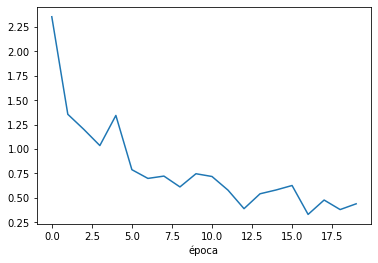

In [25]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [26]:
evaluation(model=model, loader=test_dataloader)

Accuracy: 0.6719


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        super(MyDropout, self).__init__()

    def forward(self, x: Tensor, training: bool):

        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)